# Twitch Sentiment Analysis

The goal of this project is to be able to analyse the average sentiment across a Twitch stream.

In [1]:
import os
import re
import pandas as pd
from datetime import datetime

def read_logs(path: str) -> pd.DataFrame:
    files: str = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    dataframes: array(pd.DataFrame) = []
    for file in files:
        df: pd.DataFrame = read_log(file)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

def read_log(path: str) -> pd.DataFrame:
    (stream, date) = split_file_name(path)
    
    #df = pd.DataFrame(columns=['timestamp', 'user', 'message'])
    rows = []

    with open(path, 'r') as file:
        for line in file:
            try:
                rows.append(parse_line(date, line))
            except ParseLineException as e:
                print(e)
                continue
            except NonMessageLineException as nmle:
                continue
                
#             try:
#                 # Create a new row with the parsed data and append it to the DataFrame
#                 #new_row = {'timestamp': date, 'user': user, 'message': message}
#                 #df = df.append(new_row, ignore_index=True)
#                 new_df = pd.DataFrame({'timestamp': [date], 'user': [user], 'message': [message]})
#                 rows.append(new_df)
#             except ValueError:
#                 pass
            
#     df = pd.concat(rows, ignore_index=True)
    df = pd.DataFrame(rows, columns=['ts', 'user', 'message'])
    return df

class ParseLineException(Exception):
    pass

class NonMessageLineException(Exception):
    pass

def parse_line(date: datetime.date, line: str) -> (datetime, str, str):
    pattern = r'^\[(\d{2}:\d{2}:\d{2})\]\s{2}(\w+):\s(.*)$'
    match = re.match(pattern, line)
    
    if not match:
        if re.match(r'.*\](\s{1})\w+', line):
            # announcement line, ignore
            raise NonMessageLineException(line)
        else:
            raise ParseLineException(f'failed to parse line: {line}')

    time_str = match.group(1)
    username = match.group(2)
    message = match.group(3)
    
    time_obj = datetime.strptime(time_str, '%H:%M:%S').time()
    datetime_obj = datetime.combine(date, time_obj)
    
    return (datetime_obj, username, message)

def split_file_name(path: str) -> (str, datetime.date):
    pattern = r'^(.+?)-(\d{4}-\d{2}-\d{2})\.log$'
    
    match = re.match(pattern, os.path.basename(path))
    stream_name = match.group(1)
    date_str = match.group(2)
    
    date = datetime.strptime(date_str, '%Y-%m-%d').date()
    return (stream_name, date)



In [2]:
%%time
df = read_logs('data')
df.head()

failed to parse line: # Start logging at 2023-05-11 09:08:12 CDT

failed to parse line: # Start logging at 2023-05-11 20:49:42 CDT

failed to parse line: # Start logging at 2023-05-09 17:18:50 CDT

failed to parse line: # Start logging at 2023-05-10 17:11:49 CDT

failed to parse line: [22:10:20] 

CPU times: user 225 ms, sys: 5.98 ms, total: 231 ms
Wall time: 234 ms


,ts,user,message
0,2023-05-11 09:08:18,acabmilfweed,@magnanimus86 they look so goofy lmao
1,2023-05-11 09:08:19,unsoursop,Next time he dies the character needs to be na...
2,2023-05-11 09:08:19,fxzues,at this rate we wont have summit later in the ...
3,2023-05-11 09:08:21,dovahthekiin,AngelThump
4,2023-05-11 09:08:22,und3rwearbandit,@retroinformer lol


In [3]:
df.user.value_counts().describe()

count    8490.000000
mean        5.835807
std        27.705218
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1830.000000
Name: count, dtype: float64

## VADER

First, we'll try to use VADER to classify the sentiment and add a column called `sentiment` to the `DataFrame`.

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_compound(msg: str) -> float:
    results = analyzer.polarity_scores(msg)
    return results['compound']

df['vader_compound'] = df.apply(lambda row: get_vader_compound(row.message), axis=1)
df.head()

,ts,user,message,vader_compound
0,2023-05-11 09:08:18,acabmilfweed,@magnanimus86 they look so goofy lmao,0.6344
1,2023-05-11 09:08:19,unsoursop,Next time he dies the character needs to be na...,0.0000
2,2023-05-11 09:08:19,fxzues,at this rate we wont have summit later in the ...,0.0000
3,2023-05-11 09:08:21,dovahthekiin,AngelThump,0.0000
4,2023-05-11 09:08:22,und3rwearbandit,@retroinformer lol,0.4215


<Axes: ylabel='Frequency'>

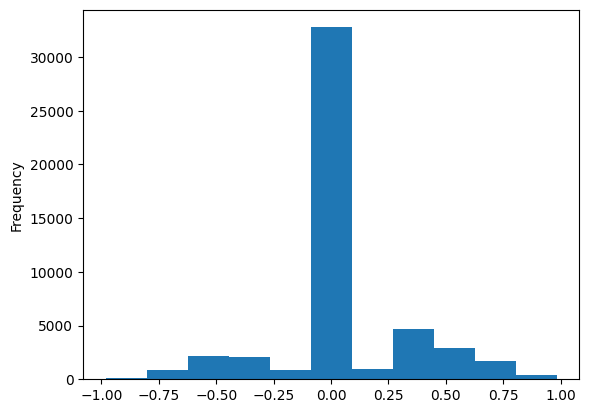

In [5]:
df.vader_compound.plot.hist(bins=11)

In [6]:
df.vader_compound.describe()

count    49546.000000
mean         0.047010
std          0.286957
min         -0.981300
25%          0.000000
50%          0.000000
75%          0.000000
max          0.982800
Name: vader_compound, dtype: float64

In [7]:
df.vader_compound.value_counts()

vader_compound
 0.0000    32225
 0.4215     1109
 0.3612      660
 0.4404      619
-0.2960      612
           ...  
 0.7156        1
-0.3744        1
 0.8700        1
 0.8344        1
-0.2278        1
Name: count, Length: 1572, dtype: int64

In [8]:
df.loc[df['vader_compound'] == 0.0].message.value_counts().head(15)

message
KEKW                                                                                                          916
o7                                                                                                            578
LUL                                                                                                           449
HUH                                                                                                           251
Catch the 1G Basics Merch collection at any time! -> https://summit1g.gg/                                     232
OMEGALUL                                                                                                      207
Pog                                                                                                           205
zooted                                                                                                        198
KEK                                                                             

## TODO
- Update the lexicon to include common words.
  - <https://github.com/wredan/Twitch-Chat-Analyzer/blob/master/Spark/Python/code/modules/sentimentAnalysis.py>
- Compare all tokens in input with the lexicon - output the most common missing.
- Python module for chatterino logs.
- Remove inputs with no tokens in the lexicon.
- Sentiment by user and channel.

See <https://stackoverflow.com/questions/40481348/is-it-possible-to-edit-nltks-vader-sentiment-lexicon>

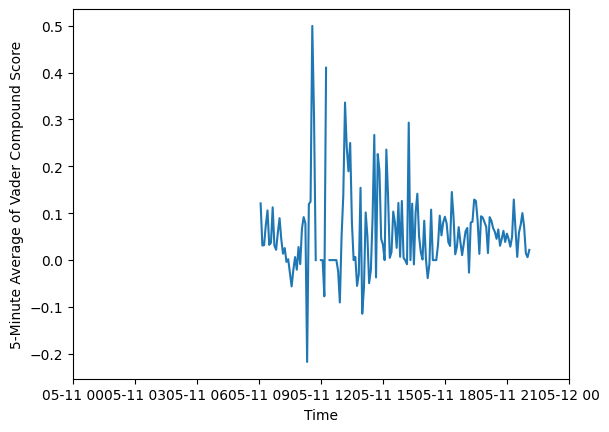

In [12]:
import matplotlib.pyplot as plt
import datetime as dt

#df['ts'] = pd.to_datetime(df['ts'])
#df.set_index('ts', inplace=True)

df.head()
#df_mean = df.resample('5T').mean()
df_mean = df.resample('5T').agg(dict(vader_compound='mean'))


plt.plot(df_mean.index, df_mean['vader_compound'])
plt.xlabel('Time')
plt.ylabel('5-Minute Average of Vader Compound Score')
plt.gca().set_xbound(dt.date(2023,5,11), dt.date(2023,5,12))
plt.show()